# Distill CLOOB-conditioned Latent Diffusion trained on WikiArt ([distill-ccld-wa](https://huggingface.co/huggan/distill-ccld-wa)) 

In [ ]:
#@title clone some libraries and install a few dependancies
!git clone --recursive https://github.com/JD-P/cloob-latent-diffusion &> /dev/null
!cd cloob-latent-diffusion;pip install omegaconf pillow pytorch-lightning einops wandb ftfy regex ./CLIP &> /dev/null
!pip install datasets &> /dev/null

In [ ]:
#@title imports, loading models and utility functions
import argparse
from functools import partial
from pathlib import Path
import sys
sys.path.append('./cloob-latent-diffusion')
sys.path.append('./cloob-latent-diffusion/cloob-training')
sys.path.append('./cloob-latent-diffusion/latent-diffusion')
sys.path.append('./cloob-latent-diffusion/taming-transformers')
sys.path.append('./cloob-latent-diffusion/v-diffusion-pytorch')
from omegaconf import OmegaConf
from PIL import Image
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from tqdm import trange
from CLIP import clip
from cloob_training import model_pt, pretrained
import ldm.models.autoencoder
from diffusion import sampling, utils
import train_latent_diffusion as train
from huggingface_hub import hf_hub_url, cached_download

# Download the model files
checkpoint = cached_download(hf_hub_url("gigant/distill-ccld", filename="model_student.ckpt"))
ae_model_path = cached_download(hf_hub_url("huggan/ccld_wa", filename="ae_model.ckpt"))
ae_config_path = cached_download(hf_hub_url("huggan/ccld_wa", filename="ae_model.yaml"))

# Define a few utility functions

def parse_prompt(prompt, default_weight=3.):
    if prompt.startswith('http://') or prompt.startswith('https://'):
        vals = prompt.rsplit(':', 2)
        vals = [vals[0] + ':' + vals[1], *vals[2:]]
    else:
        vals = prompt.rsplit(':', 1)
    vals = vals + ['', default_weight][len(vals):]
    return vals[0], float(vals[1])


def resize_and_center_crop(image, size):
    fac = max(size[0] / image.size[0], size[1] / image.size[1])
    image = image.resize((int(fac * image.size[0]), int(fac * image.size[1])), Image.LANCZOS)
    return TF.center_crop(image, size[::-1])


# Load the models
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print('loading models')
# autoencoder
ae_config = OmegaConf.load(ae_config_path)
ae_model = ldm.models.autoencoder.AutoencoderKL(**ae_config.model.params)
ae_model.eval().requires_grad_(False).to(device)
ae_model.load_state_dict(torch.load(ae_model_path))
n_ch, side_y, side_x = 4, 32, 32

# diffusion model
model = train.DiffusionModel(192, [1,1,2,2], autoencoder_scale=torch.tensor(4.3084))
model.load_state_dict(torch.load(checkpoint, map_location='cpu'))
model = model.to(device).eval().requires_grad_(False)

# CLOOB
cloob_config = pretrained.get_config('cloob_laion_400m_vit_b_16_16_epochs')
cloob = model_pt.get_pt_model(cloob_config)
checkpoint = pretrained.download_checkpoint(cloob_config)
cloob.load_state_dict(model_pt.get_pt_params(cloob_config, checkpoint))
cloob.eval().requires_grad_(False).to(device)


# The key function: returns a list of n PIL images
def generate(n=1, prompts=['a red circle'], images=[], seed=42, steps=15,
             method='plms', eta=None):
  zero_embed = torch.zeros([1, cloob.config['d_embed']], device=device)
  target_embeds, weights = [zero_embed], []

  for prompt in prompts:
      txt, weight = parse_prompt(prompt)
      target_embeds.append(cloob.text_encoder(cloob.tokenize(txt).to(device)).float())
      weights.append(weight)

  for prompt in images:
      path, weight = parse_prompt(prompt)
      img = Image.open(utils.fetch(path)).convert('RGB')
      clip_size = cloob.config['image_encoder']['image_size']
      img = resize_and_center_crop(img, (clip_size, clip_size))
      batch = TF.to_tensor(img)[None].to(device)
      embed = F.normalize(cloob.image_encoder(cloob.normalize(batch)).float(), dim=-1)
      target_embeds.append(embed)
      weights.append(weight)

  weights = torch.tensor([1 - sum(weights), *weights], device=device)

  torch.manual_seed(seed)

  def cfg_model_fn(x, t):
      n = x.shape[0]
      n_conds = len(target_embeds)
      x_in = x.repeat([n_conds, 1, 1, 1])
      t_in = t.repeat([n_conds])
      clip_embed_in = torch.cat([*target_embeds]).repeat_interleave(n, 0)
      vs = model(x_in, t_in, clip_embed_in).view([n_conds, n, *x.shape[1:]])
      v = vs.mul(weights[:, None, None, None, None]).sum(0)
      return v

  def run(x, steps):
      if method == 'ddpm':
          return sampling.sample(cfg_model_fn, x, steps, 1., {})
      if method == 'ddim':
          return sampling.sample(cfg_model_fn, x, steps, eta, {})
      if method == 'prk':
          return sampling.prk_sample(cfg_model_fn, x, steps, {})
      if method == 'plms':
          return sampling.plms_sample(cfg_model_fn, x, steps, {})
      if method == 'pie':
          return sampling.pie_sample(cfg_model_fn, x, steps, {})
      if method == 'plms2':
          return sampling.plms2_sample(cfg_model_fn, x, steps, {})
      assert False

  batch_size = n
  x = torch.randn([n, n_ch, side_y, side_x], device=device)
  t = torch.linspace(1, 0, steps + 1, device=device)[:-1]
  steps = utils.get_spliced_ddpm_cosine_schedule(t)
  pil_ims = []
  for i in trange(0, n, batch_size):
      cur_batch_size = min(n - i, batch_size)
      out_latents = run(x[i:i+cur_batch_size], steps)
      outs = ae_model.decode(out_latents * torch.tensor(2.55).to(device))
      for j, out in enumerate(outs):
          pil_ims.append(utils.to_pil_image(out))

  return pil_ims

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/405M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

Using device: cuda:0
loading models
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

8.19kB [00:00, 594kB/s]                    


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth


  0%|          | 0.00/571M [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


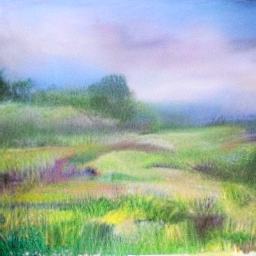

In [ ]:
# # You can generate images like so:
pil_ims = generate(n=1, prompts=['A peaceful meadow, pastel crayons']) # run the generate function
pil_ims[0] # View the first image returned

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.00s/it]


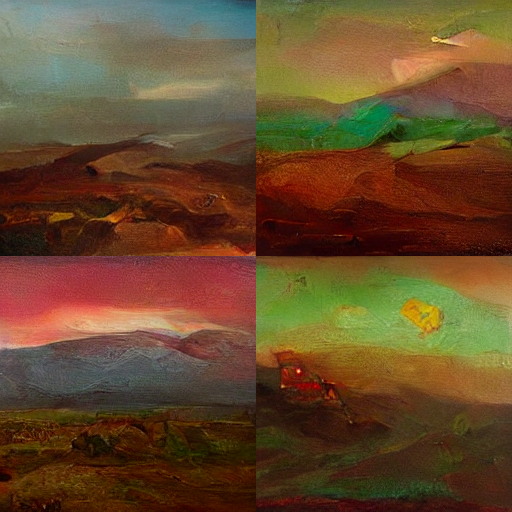

In [ ]:
# Generate 4 at once
pil_ims = generate(n=6, prompts=['A martian landscape painting, oil on canvas'])
out_image = Image.new(mode='RGB', size=(512, 512))
for i, im in enumerate(pil_ims):
  out_image.paste(im, ((i%2)*256, i//2*256))
out_image